CS5242 Final Project : Model Training Notebook
===
> Transfer learning and fine-tuning pre-trained models on ImageNet dataset

*Murat Shagirov*

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nn import train_model # model training function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from datautils import LoadTrainingData
from torch.utils.data import DataLoader
from torchvision import models, utils, transforms as T

from datautils import BatchUnnorm, Unnorm

import numpy as np
from os import path

# check for CUDA device and set default dtype
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'device: {device}\ndtype: {dtype}')

# Transforms
unnorm = Unnorm() # unnormalize a single RGB image
unnormb = BatchUnnorm() # unnormalize batch of images

toPIL = T.ToPILImage()

img_size = 512

transform = T.Compose([T.ToPILImage(),
                       T.Resize(img_size),
#                        T.RandomRotation((-3,3)),
#                        T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
                       T.RandomHorizontalFlip(),
#                        T.RandomVerticalFlip(),
                       T.ToTensor(),
                       T.ConvertImageDtype(dtype), 
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_transform = T.Compose([T.ToPILImage(),
                           T.Resize(img_size),
                           T.ToTensor(),
                           T.ConvertImageDtype(dtype),
                           T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Paths to training dataset and labels (before Train/Val split)
train_csv = path.join('./datasets','train_label.csv')
train_data_path = path.join('./datasets','train_image','train_image')

np.random.seed(42) #seed np RNG for consistency
# split the original training data into 85% / 15% train/val datasets
datasets = LoadTrainingData(train_csv, train_data_path, transform=transform,
                            split=True, train_percent=80, val_transform=val_transform)

print(f"Training dataset: {len(datasets['train'])} samples.",
      f"\nValidation dataset: {len(datasets['val'])} samples.")


device: cuda
dtype: torch.float32
Training dataset: 931 samples. 
Validation dataset: 233 samples.


In [3]:
# For plotting
import matplotlib.pyplot as plt
# for plotting figures (report)
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15,5) # use larger for presentation
matplotlib.rcParams['font.size']= 9 # use 14 for presentation

## Finetuning

- fine tuning resnet18 seems faster, and validation set acc-y is generally quickly reaches >85-90% after 5epochs
- using resnet18's conv layer as feature extractor (freezing them) results in very slow training (but no overfitting), both training and val-n set accuracies increase slowly (>80% after 5 epochs)

- densenet121: so far 25*3 epochs-->97.4249%
- resnext50_32x4d + fc: 25*1 epochs-->96.5665% (afterwards ValLoss converges to ~96%)

**Finetuning example**:<br>
```python
model_ft.classifier = nn.Linear(num_ftrs, 3)
```
- Results:
```
Epoch 0/9 --- train Loss: 0.7693 Acc: 0.6380 || val Loss: 0.4393 Acc: 0.7940 || 45s
Epoch 1/9 --- train Loss: 0.5464 Acc: 0.7487 || val Loss: 0.3655 Acc: 0.8455 || 89s
Epoch 2/9 --- train Loss: 0.4944 Acc: 0.7863 || val Loss: 0.3134 Acc: 0.8498 || 134s
Epoch 3/9 --- train Loss: 0.4431 Acc: 0.8292 || val Loss: 0.2520 Acc: 0.9142 || 178s
Epoch 4/9 --- train Loss: 0.3966 Acc: 0.8496 || val Loss: 0.2423 Acc: 0.9099 || 222s
Epoch 5/9 --- train Loss: 0.3541 Acc: 0.8571 || val Loss: 0.1994 Acc: 0.9270 || 266s
Epoch 6/9 --- train Loss: 0.3304 Acc: 0.8743 || val Loss: 0.2378 Acc: 0.9099 || 311s
Epoch 7/9 --- train Loss: 0.2757 Acc: 0.8926 || val Loss: 0.1736 Acc: 0.9185 || 355s
Epoch 8/9 --- train Loss: 0.3010 Acc: 0.8851 || val Loss: 0.1880 Acc: 0.9142 || 399s
Epoch 9/9 --- train Loss: 0.2335 Acc: 0.9119 || val Loss: 0.1970 Acc: 0.9270 || 443s
Training complete in 7m 23s
Best val Acc: 0.927039 (return best:True)
```
![](./finetune_SGD_mom09_lr0001.png)

In [15]:
num_epochs = 10

bsize_train = 4 # batch sizes
bsize_val = 4

lr = 0.001 # learning rate

model_name = 'densenet121_v3'
# Download ImageNet pre-trained model from torchhub
model_ft = models.densenet121(pretrained=True,progress=False)

# # for transfer learning freeze (disable grads for early layers)
# for param in model_ft.parameters():
#     param.requires_grad = False

# num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier.in_features

# size of each output sample: nn.Linear(num_ftrs, len(class_names)).
# e.g.: model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft.classifier = nn.Linear(num_ftrs, 3)


model_ft = model_ft.to(device)

# Finetune all parameters
criterion = nn.CrossEntropyLoss()
# SUBMISSION: SGD(LR=0.001, MOMENTUM=0.9)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.5)
# optimizer_ft = torch.optim.Adam(model_ft.fc.parameters(), lr=lr)

# LR Schedules
# exp_lr_scheduler = None
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5*len(datasets['train']), gamma=0.1)
# exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, 10**-9, 10**-4, step_size_up=5, step_size_down=10)

# Prepare dataloaders
data_loaders = {'train' : DataLoader(datasets['train'], batch_size=bsize_train, shuffle=True, num_workers=0),
                'val'   : DataLoader(datasets['val'],  batch_size=bsize_val, shuffle=False, num_workers=0)}

In [ ]:
# for submission num_epochs > 60 epochs
best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=num_epochs,
                         loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True)

# UNCOMMENT below for plotting loss and accuracy

plt.figure(figsize=[20,8])
t = np.arange(curve_data['total_epochs'])
plt.subplot(121)
plt.plot(t,curve_data['trainLosses'],label='Train')
plt.plot(t,curve_data['valLosses'],label='Val')
plt.title('Loss'); plt.legend()

plt.subplot(122)
plt.plot(t,curve_data['trainAccs'],label='Train')
plt.plot(t,curve_data['valAccs'],label='Val')
plt.title('Accuracy'); plt.legend()

plt.show()

In [8]:
# # ======================================================= #
# # ------------------- MODEL CHECKPOINT ------------------ #
# # ======================================================= #
# # Save (current) best model:
# model_fname = 'densenet121_ft_512px_short' # file name
# save_dir = '../../dataDIR/cs5242/' # path to folder

# torch.save(best_model.state_dict(), f'./{path.join(save_dir, model_fname)}.pkl')
# # Save training/val losses and accuracies for plotting 
# torch.save(curve_data,f'./{path.join(save_dir, model_fname)}_plot.pkl')

In [ ]:
# For changing LR-policy:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5*len(datasets['train']),
                                       gamma=0.1, last_epoch=10*len(datasets['train']))

# continue training:
best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=30,
                         loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True)

plt.figure(figsize=[20,8])
t = np.arange(curve_data['total_epochs'])
plt.subplot(121)
plt.plot(t,curve_data['trainLosses'],label='Train')
plt.plot(t,curve_data['valLosses'],label='Val')
plt.title('Loss'); plt.legend()

plt.subplot(122)
plt.plot(t,curve_data['trainAccs'],label='Train')
plt.plot(t,curve_data['valAccs'],label='Val')
plt.title('Accuracy'); plt.legend()

plt.show()

In [8]:
# ======================================================= #
# ------------------- MODEL CHECKPOINT ------------------ #
# ======================================================= #
# Save (current) best model:
model_fname = 'densenet121_ft_512px_long' # file name
save_dir = '../../dataDIR/cs5242/' # path to folder

torch.save(best_model.state_dict(), f'./{path.join(save_dir, model_fname)}.pkl')
# Save training/val losses and accuracies for plotting 
torch.save(curve_data,f'./{path.join(save_dir, model_fname)}_plot.pkl')

---
# Transfer Learning
---

Training classifier with *SGD is very sensitive to hyperparam-s*, eps.for >1 layer classifiers, larger the classifier more sensitive it is to hyperparam-s. Had to switch and tune ADAM.
- Adam--> faced overfitting, tuned dropout rates, decreased number of units in classifier's layers

- results for SGD(mom=0.8) lr=0.03
```python
model_ft.classifier = nn.Sequential(nn.Linear(num_ftrs, 256),
                                     nn.ReLU(),
                                     nn.Dropout(0.1),
                                    nn.Linear(256, 128),
                                     nn.ReLU(),
                                     nn.Dropout(0.1),
                                     nn.Linear(128, 64),
                                     nn.ReLU(),
                                     nn.Dropout(0.1),
                                     nn.Linear(64, 3))
```
```
Epoch 0/4 --- train Loss: 0.9793 Acc: 0.5081  (val Loss: 0.7355 Acc: 0.6481) || 27s
Epoch 1/4 --- train Loss: 0.7434 Acc: 0.6391  (val Loss: 0.7695 Acc: 0.6309) || 53s
Epoch 2/4 --- train Loss: 0.7195 Acc: 0.6617 (val Loss: 0.5591 Acc: 0.6867) || 79s
Epoch 3/4 --- train Loss: 0.6148 Acc: 0.7046 (val Loss: 0.4117 Acc: 0.8240;Best val Acc) || 105s
Epoch 4/4 --- train Loss: 0.6088 Acc: 0.6971 (val Loss: 0.5390 Acc: 0.7210) || 132s
Training complete in 2m 12s
```


![](./transfer_sgd_mom08_lr003.png)

- results for ADAM

```python
lr = 0.001 # learning rate for SGD ~0.03 : Adam->lr = 0.001 
model_ft.classifier = nn.Sequential(nn.Linear(num_ftrs, 512),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(512),
                                    nn.Dropout(0.3),
                                    nn.Linear(512, 64),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(64),
                                    nn.Dropout(0.2),
                                    nn.Linear(64, 32),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(32),
                                    nn.Dropout(0.2),
                                    nn.Linear(32, 16),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(16),
                                    nn.Dropout(0.1),
                                    nn.Linear(16, 3))
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10*len(datasets['train']), gamma=0.3)
```
```
Epoch 0/299 --- train Loss: 0.8737 Acc: 0.6122 || val Loss: 0.5892 Acc: 0.7554 || 22s
Epoch 1/299 --- train Loss: 0.7317 Acc: 0.6735 || val Loss: 0.5936 Acc: 0.7897 || 44s
Epoch 2/299 --- train Loss: 0.6752 Acc: 0.7132 || val Loss: 0.5663 Acc: 0.8369 || 67s
Epoch 3/299 --- train Loss: 0.6533 Acc: 0.7261 || val Loss: 0.5991 Acc: 0.8069 || 89s
Epoch 4/299 --- train Loss: 0.6179 Acc: 0.7444 || val Loss: 0.5779 Acc: 0.7940 || 111s
Epoch 5/299 --- train Loss: 0.6614 Acc: 0.7003 || val Loss: 0.5339 Acc: 0.8584 || 133s
Epoch 6/299 --- train Loss: 0.6068 Acc: 0.7476 || val Loss: 0.5261 Acc: 0.8283 || 156s
Epoch 7/299 --- train Loss: 0.5893 Acc: 0.7508 || val Loss: 0.4360 Acc: 0.8584 || 178s
Epoch 8/299 --- train Loss: 0.5736 Acc: 0.7637 || val Loss: 0.5118 Acc: 0.8369 || 201s
Epoch 9/299 --- train Loss: 0.5378 Acc: 0.7744 || val Loss: 0.4693 Acc: 0.8584 || 223s
Epoch 10/299 --- train Loss: 0.5430 Acc: 0.7723 || val Loss: 0.4342 Acc: 0.8584 || 245s
Epoch 11/299 --- train Loss: 0.5199 Acc: 0.7669 || val Loss: 0.4565 Acc: 0.8755 || 268s
Epoch 12/299 --- train Loss: 0.4967 Acc: 0.7938 || val Loss: 0.4415 Acc: 0.8627 || 290s
Epoch 13/299 --- train Loss: 0.5496 Acc: 0.7830 || val Loss: 0.4539 Acc: 0.8584 || 312s
Epoch 14/299 --- train Loss: 0.5395 Acc: 0.7852 || val Loss: 0.4682 Acc: 0.8798 || 335s
Epoch 15/299 --- train Loss: 0.5237 Acc: 0.7787 || val Loss: 0.4553 Acc: 0.8584 || 358s
Epoch 16/299 --- train Loss: 0.5041 Acc: 0.7744 || val Loss: 0.4642 Acc: 0.8155 || 380s
Epoch 17/299 --- train Loss: 0.4970 Acc: 0.7873 || val Loss: 0.3876 Acc: 0.8712 || 403s
Epoch 18/299 --- train Loss: 0.4964 Acc: 0.8024 || val Loss: 0.4375 Acc: 0.8455 || 426s
Epoch 19/299 --- train Loss: 0.5062 Acc: 0.7938 || val Loss: 0.4675 Acc: 0.8541 || 448s
Epoch 20/299 --- train Loss: 0.4547 Acc: 0.8281 || val Loss: 0.4031 Acc: 0.8927 || 470s
```

In [17]:
# ======================================================= #
# ------------------ Transfer Learning ------------------ #
# ======================================================= #
# My attempts on transfer learning
# fine-tuning results (above) were always better.
# Probable cause: I suspect, I did not disable BN layers in the convnet layers properly.
# Transfer learning performance on val dataset:
# - SGD moment0.9 lr=0.01: >90% (25 epochs)
# - SGD //-// lr= 0.01 step(20 epochs decay): 92% (100 epochs)
# ------------------------------------------------------- #

num_epochs = 25

bsize_train = 4 # batch sizes
bsize_val = 4

lr = 0.001 # learning rate for SGD ~0.03 : Adam->lr = 0.001 

# Download ImageNet pre-trained model from torchhub
# model_ft = models.resnet18(pretrained=True,progress=False)
model_ft = models.densenet121(pretrained=True,progress=False)
# for transfer learning freeze (disable grads for early layers)
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.eval()

num_ftrs = model_ft.classifier.in_features
# # size of each output sample: nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Sequential(nn.Linear(num_ftrs, 512),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(512),
                                    nn.Dropout(0.3),
                                    nn.Linear(512, 64),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(64),
                                    nn.Dropout(0.2),
                                    nn.Linear(64, 32),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(32),
                                    nn.Dropout(0.2),
                                    nn.Linear(32, 16),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(16),
                                    nn.Dropout(0.1),
                                    nn.Linear(16, 3))
# model_ft.classifier = nn.Linear(num_ftrs, 3)
model_ft.classifier.train();

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.classifier.parameters(), lr=lr, momentum=0.8)
optimizer_ft = torch.optim.Adam(model_ft.classifier.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = None
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10*len(datasets['train']), gamma=0.3)
# exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, 10**-9, 10**-4,
#                                          step_size_up=5, step_size_down=10)

# Prepare dataloaders
data_loaders = {'train' : DataLoader(datasets['train'], batch_size=bsize_train, shuffle=True, num_workers=0),
                'val'   : DataLoader(datasets['val'],  batch_size=bsize_val, shuffle=False, num_workers=0)}


Epoch 0/24 --- train Loss: 0.8931 Acc: 0.5908 || val Loss: 0.6707 Acc: 0.7811 || 23s
Epoch 1/24 --- train Loss: 0.7311 Acc: 0.6735 || val Loss: 0.6113 Acc: 0.7897 || 45s
Epoch 2/24 --- train Loss: 0.6868 Acc: 0.6928 || val Loss: 0.5480 Acc: 0.8240 || 67s
Epoch 3/24 --- train Loss: 0.6547 Acc: 0.7325 || val Loss: 0.4769 Acc: 0.8584 || 89s
Epoch 4/24 --- train Loss: 0.6765 Acc: 0.7143 || val Loss: 0.5527 Acc: 0.8455 || 111s
Epoch 5/24 --- train Loss: 0.6288 Acc: 0.7250 || val Loss: 0.4842 Acc: 0.8412 || 134s
Epoch 6/24 --- train Loss: 0.6138 Acc: 0.7465 || val Loss: 0.4626 Acc: 0.8627 || 156s
Epoch 7/24 --- train Loss: 0.5758 Acc: 0.7573 || val Loss: 0.4818 Acc: 0.8240 || 178s
Epoch 8/24 --- train Loss: 0.5597 Acc: 0.7626 || val Loss: 0.4786 Acc: 0.8798 || 200s
Epoch 9/24 --- train Loss: 0.5804 Acc: 0.7444 || val Loss: 0.4889 Acc: 0.8541 || 223s
Epoch 10/24 --- train Loss: 0.5885 Acc: 0.7669 || val Loss: 0.4433 Acc: 0.8798 || 246s
Epoch 11/24 --- train Loss: 0.6000 Acc: 0.7530 || val Los

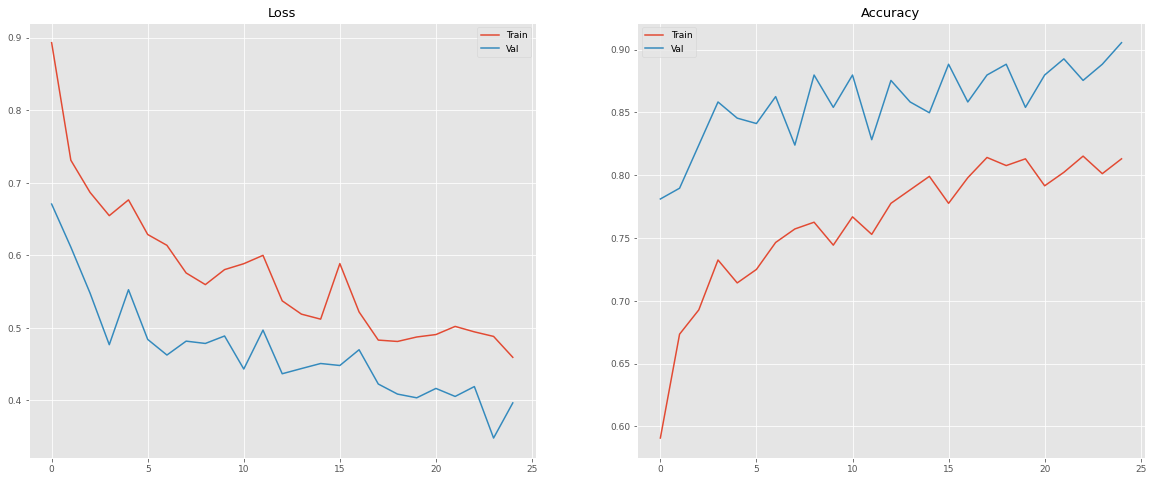

In [18]:
best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=num_epochs,
                         loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True,
                                     classifier=model_ft.classifier)

plt.figure(figsize=[20,8])
t = np.arange(curve_data['total_epochs'])
plt.subplot(121)
plt.plot(t,curve_data['trainLosses'],label='Train')
plt.plot(t,curve_data['valLosses'],label='Val')
plt.title('Loss'); plt.legend()

plt.subplot(122)
plt.plot(t,curve_data['trainAccs'],label='Train')
plt.plot(t,curve_data['valAccs'],label='Val')
plt.title('Accuracy'); plt.legend()

plt.show()

- finetuning after transfer learning (Adam)

In [19]:
num_epochs = 100

lr = 0.0001 # learning rate

for param in model_ft.parameters():
    param.requires_grad = True

# Finetune all parameters
criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=lr)

# LR Schedules
# exp_lr_scheduler = None
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10*len(datasets['train']), gamma=0.1)
# exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, 10**-9, 10**-4, step_size_up=5, step_size_down=10)

Epoch 0/99 --- train Loss: 0.2990 Acc: 0.8980 || val Loss: 0.2760 Acc: 0.9528 || 44s
Epoch 1/99 --- train Loss: 0.2705 Acc: 0.9151 || val Loss: 0.2723 Acc: 0.9442 || 86s
Epoch 2/99 --- train Loss: 0.3044 Acc: 0.9098 || val Loss: 0.2530 Acc: 0.9571 || 131s
Epoch 3/99 --- train Loss: 0.3379 Acc: 0.8840 || val Loss: 0.2856 Acc: 0.9485 || 174s
Epoch 4/99 --- train Loss: 0.2924 Acc: 0.9098 || val Loss: 0.2959 Acc: 0.9399 || 217s
Epoch 5/99 --- train Loss: 0.2697 Acc: 0.9216 || val Loss: 0.2982 Acc: 0.9485 || 262s
Epoch 6/99 --- train Loss: 0.2494 Acc: 0.9280 || val Loss: 0.2981 Acc: 0.9270 || 305s
Epoch 7/99 --- train Loss: 0.2926 Acc: 0.9087 || val Loss: 0.2878 Acc: 0.9614 || 350s
Epoch 8/99 --- train Loss: 0.3032 Acc: 0.8980 || val Loss: 0.2459 Acc: 0.9571 || 394s
Epoch 9/99 --- train Loss: 0.2762 Acc: 0.9184 || val Loss: 0.3002 Acc: 0.9485 || 439s
Epoch 10/99 --- train Loss: 0.2876 Acc: 0.9162 || val Loss: 0.2877 Acc: 0.9442 || 484s
Epoch 11/99 --- train Loss: 0.2731 Acc: 0.9033 || val L

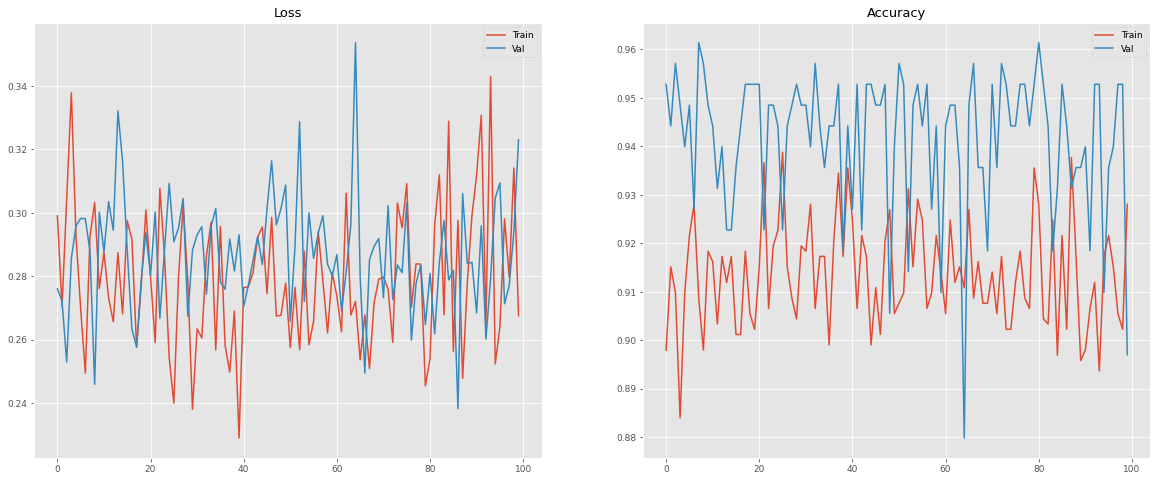

In [21]:
best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=num_epochs,
                         loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True)

plt.figure(figsize=[20,8])
t = np.arange(curve_data['total_epochs'])
plt.subplot(121)
plt.plot(t,curve_data['trainLosses'],label='Train')
plt.plot(t,curve_data['valLosses'],label='Val')
plt.title('Loss'); plt.legend()

plt.subplot(122)
plt.plot(t,curve_data['trainAccs'],label='Train')
plt.plot(t,curve_data['valAccs'],label='Val')
plt.title('Accuracy'); plt.legend()

plt.show()

- results for finetuning after transfer learning (Adam):


- Continuing training

In [52]:
optimizer_ft = optim.SGD(model_ft.classifier.parameters(), lr=10**-6, momentum=0.)
exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, 10**-9, 10**-4, step_size_up=2000, step_size_down=2000)

In [ ]:
best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=1000,
                         loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True)

plt.figure(figsize=[20,8])
t = np.arange(curve_data['total_epochs'])
plt.subplot(121)
plt.plot(t,curve_data['trainLosses'],label='Train')
plt.plot(t,curve_data['valLosses'],label='Val')
plt.title('Loss'); plt.legend()

plt.subplot(122)
plt.plot(t,curve_data['trainAccs'],label='Train')
plt.plot(t,curve_data['valAccs'],label='Val')
plt.title('Accuracy'); plt.legend()

plt.show()

In [42]:
train_method = 'transfer'
model_name = 'densenet121'
save_dir = '../../dataDIR/cs5242/'
weights_path = path.join(save_dir, f'{model_name}_{train_method}_02NOV2020.pkl')
torch.save(best_model.state_dict(), weights_path)
torch.save(curve_data,f'./{model_name}_{train_method}__02NOV2020_plot.pkl')

In [ ]:
# ======================================================= #
# ---------- Fine tuning for transfer learning: --------- #
# ======================================================= #
# Uncomment this section for fine-tuning (after pre-training the classifier/ FC layer)

# num_epochs = 50

# # re-enable grads for fine-tuning
# for param in model_ft.parameters():
#     param.requires_grad = True
# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.9)
# # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
# exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, 10**-9, 10**-4,
#                                          step_size_up=5, step_size_down=10)

# best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=num_epochs,
#                          loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True)

# plt.figure(figsize=[20,8])
# t = np.arange(curve_data['total_epochs'])
# plt.subplot(121)
# plt.plot(t,curve_data['trainLosses'],label='Train')
# plt.plot(t,curve_data['valLosses'],label='Val')
# plt.title('Loss'); plt.legend()

# plt.subplot(122)
# plt.plot(t,curve_data['trainAccs'],label='Train')
# plt.plot(t,curve_data['valAccs'],label='Val')
# plt.title('Accuracy'); plt.legend()

# plt.show()
# ======================================================= #